<a href="https://colab.research.google.com/github/Noora66612/Optimizing-Mobile-Game-Retention/blob/main/Optimizing_Mobile_Game_Retention_Gate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing Mobile Game Retention: Gate 30 vs. Gate 40 (A/B Testing)

Author: PinChen Shih

Date: 2025-12

Project Goal: To determine if moving the first gate affects player retention using statistical analysis.

## 1. Hypothesis

*   **Business Context**: Cookie Cats is a
popular mobile puzzle game. The product team is considering moving the first gate from Level 30 to Level 40.

*   **The Problem**: While moving the gate might extend the initial gameplay, we are concerned it could negatively impact player retention (churn).


*   **H0**: Moving the gate to level 40 has no impact on 7-day retention.

*   **H1**: There is a significant difference in retention rates between the two groups.

## 2. Methodology & Data Overview

### Experimental Design
* **Target:** 90,189 players who installed the game.
* **Groups:**
    * **Control:** Gate at Level 30.
    * **Treatment:** Gate at Level 40.

### Dataset Features
* `userid`: A unique number that identifies each player.
* `version`: Whether the player was put in the control group (**gate_30**) or the test group (**gate_40**).
* `sum_gamerounds`: The number of game rounds played by the player during the first 14 days after install.
* `retention_1`: Did the player come back and play **1 day** after installing?
* `retention_7`: Did the player come back and play **7 days** after installing?

### Data Cleaning
We observed outliers with unrealistic game rounds (e.g., > 40,000). To ensure statistical integrity, these extreme outliers are removed.

* **Outlier Handling**: Removing players with unrealistic game rounds... (這裡放你的 pd.read_csv 和 outlier removal 的程式碼)

Data loaded successfully.

--- Missing Values Check ---
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

--- Duplicate User IDs: 0 ---

--- Sample Size Check (Gate 30 vs 40)---
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


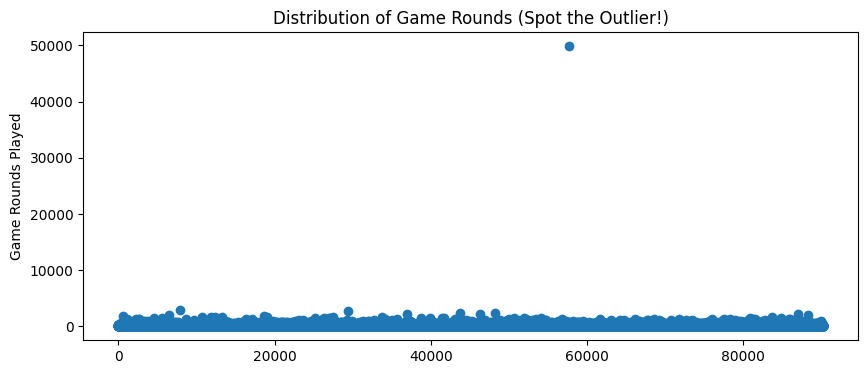


--- Top 10 Game Rounds ---
[49854  2961  2640  2438  2294  2251  2156  2124  2063  2015]


In [15]:
# --- 1. Setup & Data Loading ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
# Ensure 'cookie_cats.csv' is uploaded to your Colab environment
try:
    df = pd.read_csv('cookie_cats.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'cookie_cats.csv' not found.")
else:
      # 2. Check for Missing Values
      print("\n--- Missing Values Check ---")
      print(df.isnull().sum())

      # 3. Check for Duplicate User IDs
      # User IDs should be unique
      duplicates = df['userid'].duplicated().sum()
      print(f"\n--- Duplicate User IDs: {duplicates} ---")

      # 4. Check Sample Size Balance (Gate 30 vs 40)
      print("\n--- Sample Size Check (Gate 30 vs 40)---")
      print(df['version'].value_counts())

      # 5. Check for Outliers
      # Use a Scatter Plot to visualize the distribution
      plt.figure(figsize=(10, 4))
      plt.scatter(range(len(df)), df['sum_gamerounds'])
      plt.title("Distribution of Game Rounds (Spot the Outlier!)")
      plt.ylabel("Game Rounds Played")
      plt.show()

      # Print the game rounds for the top 10 players
      print("\n--- Top 10 Game Rounds ---")
      print(df['sum_gamerounds'].nlargest(10).values)

In [16]:
# --- 2: Data Cleaning ---

# Based on the observations from Step 1, we identified an extreme outlier (49854).
# To ensure statistical accuracy, we remove this outlier (keep data < 40000).

df_clean = df[df['sum_gamerounds'] < 40000].copy()

# Verify the results after removal
print(f"Original rows: {df.shape[0]}")
print(f"Cleaned rows:  {df_clean.shape[0]}")
print(f"Outliers removed: {df.shape[0] - df_clean.shape[0]}")

Original rows: 90189
Cleaned rows:  90188
Outliers removed: 1


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


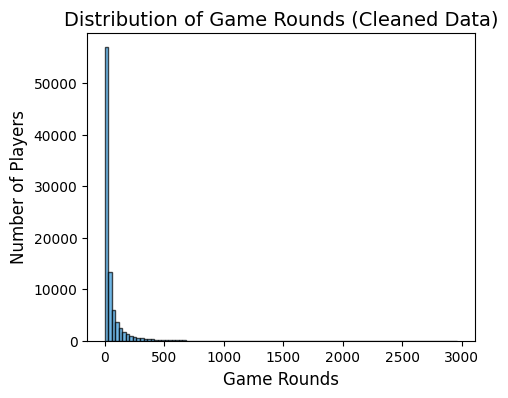


--- Summary Statistics (Game Rounds) ---
count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64


In [17]:
# --- 3. Post-Cleaning Data Check ---
# Visualize the distribution of game rounds AFTER removing outliers
# Confirms that the data distribution is now reasonable.

plt.figure(figsize=(5, 4))
plt.title("Distribution of Game Rounds (Cleaned Data)", fontsize=14)
plt.xlabel("Game Rounds", fontsize=12)
plt.ylabel("Number of Players", fontsize=12)

# Plot histogram
plt.hist(df_clean['sum_gamerounds'], bins=100, color='#3498db', edgecolor='black', alpha=0.7)
plt.show()

# Print summary statistics for game rounds
print("\n--- Summary Statistics (Game Rounds) ---")
print(df_clean['sum_gamerounds'].describe())

## 3. Metrics & Statistical Analysis

We focus on two key metrics to evaluate player retention:

*   **1-Day Retention**: The percentage of players who return 1 day after installation.
*   **7-Day Retention**: The percentage of players who return 7 days after installation (Primary KPI).

We use **Bootstrap Analysis** to visualize the uncertainty and **Z-test** to confirm statistical significance.

### Statistical Approach:


1.   **Descriptive Statistics**: Calculate the absolute retention rates for both groups.
2.   **Z-Test**: Determine if the difference in retention rates is statistically significant (p<0.05).
3.   **Bootstrap Analysis**: Estimate the certainty of the difference by resampling the data 500 times.







In [18]:
# --- 1. Metrics & Z-Test ---
from statsmodels.stats.proportion import proportions_ztest

# 1. Calculate Retention Rates (Descriptive Statistics)
# Group by version and calculate the mean of retention flags (True=1, False=0)
retention_results = df_clean.groupby('version').agg({
    'userid': 'count',
    'retention_1': 'mean',
    'retention_7': 'mean'
}).reset_index()

# Rename columns for clarity
retention_results.columns = ['Version', 'Sample Size', '1-Day Retention', '7-Day Retention']

print("--- Retention Rates by Group ---")
print(retention_results)

# 2. Perform Z-Test for 7-Day Retention (Primary KPI)
# Define success counts and sample sizes
control_group = df_clean[df_clean['version'] == 'gate_30']
treatment_group = df_clean[df_clean['version'] == 'gate_40']

success_counts = [control_group['retention_7'].sum(), treatment_group['retention_7'].sum()]
nobs = [len(control_group), len(treatment_group)]

# Run Z-test
z_stat, p_value = proportions_ztest(success_counts, nobs)

print(f"\n--- Z-Test Results (7-Day Retention) ---")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value:     {p_value:.4f}")

# Verdict
if p_value < 0.05:
    print("Verdict: Statistically Significant! (Reject Null Hypothesis)")
else:
    print("Verdict: No Significant Difference.")

--- Retention Rates by Group ---
   Version  Sample Size  1-Day Retention  7-Day Retention
0  gate_30        44699         0.448198         0.190183
1  gate_40        45489         0.442283         0.182000

--- Z-Test Results (7-Day Retention) ---
Z-statistic: 3.1574
P-value:     0.0016
Verdict: Statistically Significant! (Reject Null Hypothesis)


In [19]:
# --- 2. Calculate Relative Lift ---

# 1. Get the retention rates from the table
retention_30 = retention_results.loc[retention_results['Version'] == 'gate_30', '7-Day Retention'].values[0]
retention_40 = retention_results.loc[retention_results['Version'] == 'gate_40', '7-Day Retention'].values[0]

# 2. Calculate Relative Difference: (New - Old) / Old
relative_lift = (retention_30 - retention_40) / retention_40 * 100

print(f"\n--- Business Metric: Relative Lift ---")
print(f"Gate 30 (1-Day): {retention_30:.2%}")
print(f"Gate 40 (7-Day): {retention_40:.2%}")
print(f"Relative Lift:   {relative_lift:.2f}%")

if relative_lift > 0:
    print(f"Conclusion: Gate 30 retains {relative_lift:.2f}% more users relative to Gate 40.")
else:
    print(f"Conclusion: Gate 30 performs worse.")


--- Business Metric: Relative Lift ---
Gate 30 (1-Day): 19.02%
Gate 40 (7-Day): 18.20%
Relative Lift:   4.50%
Conclusion: Gate 30 retains 4.50% more users relative to Gate 40.


In [20]:
# --- 3. Engagement Analysis (Game Rounds) ---

# Calculate Average Game Rounds per User for each group
rounds_30 = df_clean.loc[df_clean['version'] == 'gate_30', 'sum_gamerounds'].mean()
rounds_40 = df_clean.loc[df_clean['version'] == 'gate_40', 'sum_gamerounds'].mean()

print(f"\n--- Engagement Metric: Game Rounds ---")
print(f"Gate 30 (Avg Rounds): {rounds_30:.2f}")
print(f"Gate 40 (Avg Rounds): {rounds_40:.2f}")

# Calculate difference
diff_rounds = rounds_30 - rounds_40
print(f"Difference: {diff_rounds:.2f} rounds per user")

# 判斷邏輯：如果差異小於 1 回合，視為持平
if abs(diff_rounds) < 1:
    print("Insight: Engagement is STABLE (No negative impact).")
    print("This confirms that Gate 30 improves retention without reducing player activity.")
elif diff_rounds > 0:
    print("Insight: Gate 30 users played MORE rounds on average (Better for Ad Revenue).")
else:
    print("Insight: Gate 30 users played FEWER rounds (Better for Content Pacing).")


--- Engagement Metric: Game Rounds ---
Gate 30 (Avg Rounds): 51.34
Gate 40 (Avg Rounds): 51.30
Difference: 0.04 rounds per user
Insight: Engagement is STABLE (No negative impact).
This confirms that Gate 30 improves retention without reducing player activity.



Running Bootstrap resampling (500 iterations)...


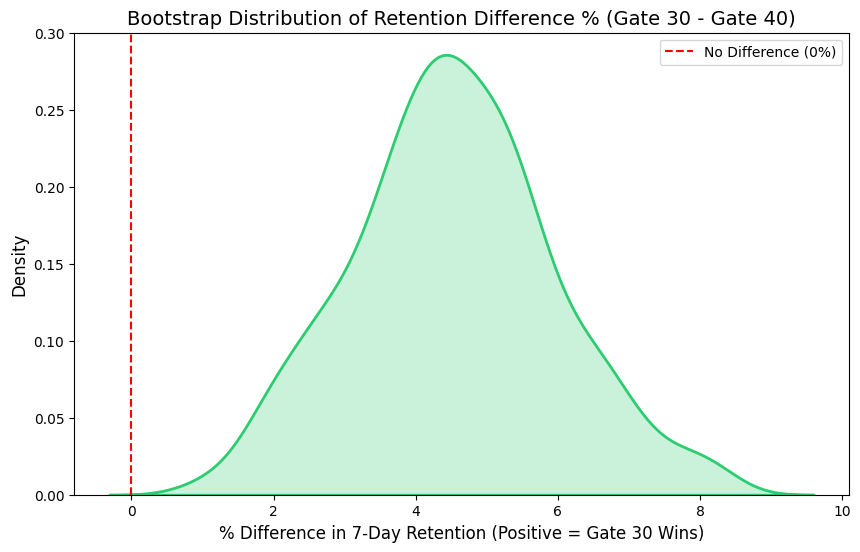

Probability that Gate 30 > Gate 40: 100.0%


In [21]:
# --- 4. Bootstrap Analysis ---
import seaborn as sns

# Configure parameters
iterations = 500
boot_diff = []

print(f"\nRunning Bootstrap resampling ({iterations} iterations)...")

# Resampling Loop
for i in range(iterations):
    # Resample with replacement
    boot_sample = df_clean.sample(frac=1, replace=True)

    # Calculate retention for both groups in this sample
    boot_means = boot_sample.groupby('version')['retention_7'].mean()

    # Calculate % difference (Gate 30 - Gate 40)
    # Positive difference means Gate 30 is better
    diff = (boot_means['gate_30'] - boot_means['gate_40']) / boot_means['gate_40'] * 100
    boot_diff.append(diff)

# Create a DataFrame for plotting
boot_df = pd.DataFrame(boot_diff, columns=['difference'])

# Plotting the Bootstrap Distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(boot_df['difference'], fill=True, color='#2ecc71', linewidth=2)
plt.axvline(0, color='red', linestyle='--', label='No Difference (0%)')

plt.title('Bootstrap Distribution of Retention Difference % (Gate 30 - Gate 40)', fontsize=14)
plt.xlabel('% Difference in 7-Day Retention (Positive = Gate 30 Wins)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

# Calculate probability of Gate 30 being better
prob_win = (boot_df['difference'] > 0).mean()
print(f"Probability that Gate 30 > Gate 40: {prob_win:.1%}")

## 4. Trade-offs & Deep Dive

### The Psychology: Why did Gate 30 win?
Based on the data, the result contradicts the initial hypothesis (that allowing players to play longer would improve retention). The likely explanation lies in the psychological concept of **"Hedonic Adaptation"**.

#### 1. The "Binge-Playing" Risk (Gate 40)
When the gate is moved to Level 40, players engage in prolonged gameplay sessions during their initial experience.

* **Trade-off:** While they experience more content upfront, they are more susceptible to **boredom and burnout**. Their enjoyment plateaus faster because there is no forced break to reset their "hedonic adaptation."

#### 2. The Value of Constraints (Gate 30)
By placing the gate earlier at Level 30, we enforce a mandatory break.

* **Benefit:** This break prevents players from consuming the content too quickly. It sustains their **"hunger"** and enjoyment for the game. Our data confirms this: despite the blockage, total game rounds remained stable, proving that players didn't quit—they just paced themselves. This increases the likelihood that they will return a week later.

> **Conclusion on Trade-offs:**
> We trade a small amount of initial user freedom (by blocking them at L30) to gain a significant increase in long-term engagement. The data proves this is a profitable trade-off.

## 5. Business Impact: From Retention to Revenue

**Conclusion:** We reject the Null Hypothesis.
**Recommendation:** Keep the gate at Level 30.
**Impact:** Preventing a **~4.5% drop** in the long-term user base.

While the psychological analysis explains *why* players stayed, this section details *how* the metrics translate to business value. By prioritizing retention, we achieved a "Quality Growth" model without sacrificing engagement.

### 1. Lifetime Value (LTV) Projection
The significant lift in 7-day retention is the strongest proxy for LTV growth.
* **The Metric:** **+4.5% Relative Lift** in D7 Retention.
* **Analysis:** Retention is a leading indicator of LTV. By keeping an additional ~4.5% of users in the ecosystem after the first week, we mathematically increase the pool of active players available for monetization (both Ads and IAP), effectively raising the ceiling for total revenue.

### 2. Engagement Stability (The "Safety" Check)
A major risk of placing a gate early (Level 30) is that it might reduce player activity. Our data proves this did not happen.
* **The Metric:** Average Game Rounds per user remained **flat (Stable)**.
* **Analysis:** Despite the mandatory break at Level 30, players did not play less overall compared to the Gate 40 group. This confirms that **Gate 30 creates a healthy pacing without reducing ad inventory**. We successfully retained more users while maintaining the same level of per-user engagement.

### 3. Content Economy Efficiency
* **Finding:** We extended the player lifecycle without increasing the rate of content consumption.
* **Takeaway:** By preventing "binge-playing" (as seen in the Gate 40 group), we maximize the **Return on Investment (ROI)** for each level produced. We keep players engaged for more days using the same amount of content, giving the development team more buffer time to create new levels while maintaining a healthy DAU.

> **Final Verdict:**
> The Gate 30 strategy creates a **"High Retention, Stable Engagement"** ecosystem. It prevents a 4.5% loss in our core user base without any negative side effects on player activity. This is the optimal setup for long-term game health and sustainable revenue.